In [4]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [5]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [6]:
beta = 0.99
sigma = 6
kappa = 0.024
rho_r = 0.35
rho_u = 0.35
sigma_r = 13.8
sigma_u = 0.17
lambda_x = 0.048
lambda_i = 0.236
x_star = 0.0
i_star = (1/beta) - 1

In [7]:
A = np.array([
    [1, 0, 0, 0, 0],
    [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
    [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
    [0, 0, 0, rho_u, 0],
    [0, 0, 0, 0, rho_r]
])

B = np.array([
    [0],
    [0],
    [sigma],
    [0],
    [0]
])

# Define LQ problem weight matrices
Q = np.array([[lambda_i]])
R = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, lambda_x, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

# Initialize LQ problem and solve
lq = LQ(Q, R, A, B, beta=beta)
P, F, d = lq.stationary_values()

# Print F matrix and verify F4, F5 values
print(f"F matrix (optimal feedback rule):\n{F}")
print(f"\nVerify F4 and F5 are approximately zero:")
print(f"F4 ≈ 0: {np.abs(F[0, 3]) < 1e-10}")
print(f"F5 ≈ 0: {np.abs(F[0, 4]) < 1e-10}")

# Calculate Taylor rule coefficients
phi_pi = -F[0, 1]
phi_x = -F[0, 2]
phi_0 = -F[0, 0] + F[0, 2] * x_star + i_star

# Print optimal Taylor rule coefficients
print(f"\nOptimal Taylor rule: i_t = {phi_pi:.4f}*π_t + {phi_x:.4f}*x_t + {phi_0:.4f}")

F matrix (optimal feedback rule):
[[ 1.18078186 -1.33491356  1.14467914  1.49042547 -1.02542563]]

Verify F4 and F5 are approximately zero:
F4 ≈ 0: False
F5 ≈ 0: False

Optimal Taylor rule: i_t = 1.3349*π_t + -1.1447*x_t + -1.1707


In [8]:
def simulate_irf(A, B, F, shock_type, shock_size=1.0, periods=40):

    # Initialize state vector and storage
    n_states = A.shape[0]
    state = np.zeros(n_states)
    # Set initial shock
    if shock_type == 'demand':
        state[4] = shock_size  # Demand shock r^n
    elif shock_type == 'cost_push':
        state[3] = shock_size  # Cost-push shock u
    # Arrays to store results
    states_history = np.zeros((periods, n_states))
    interest_rates = np.zeros(periods)
    # Simulate dynamic system
    for t in range(periods):
        states_history[t] = state
        # Calculate optimal interest rate (i_t = -F·s_t)
        interest_rates[t] = -F @ state
        # Update state (s_{t+1} = A·s_t + B·i_t)
        state = A @ state + B @ (-F @ state)
    # Extract results
    inflation = states_history[:, 1]       # π_t
    output_gap = states_history[:, 2]      # x_t

    return {
        'inflation': inflation,
        'output_gap': output_gap,
        'interest_rate': interest_rates,
        'time': np.arange(periods)
    }

def plot_irfs(demand_irf, cost_push_irf):
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    # Demand shock IRF (r^n shock)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(demand_irf['time'], demand_irf['inflation'], 'b-', linewidth=2)
    ax1.set_title('Demand Shock: Inflation Response')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Inflation Deviation')
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(demand_irf['time'], demand_irf['output_gap'], 'g-', linewidth=2)
    ax2.set_title('Demand Shock: Output Gap Response')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Output Gap Deviation')
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(demand_irf['time'], demand_irf['interest_rate'], 'r-', linewidth=2)
    ax3.set_title('Demand Shock: Interest Rate Response')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Interest Rate Deviation')
    ax3.grid(True)

    # Cost-push shock IRF (u shock)
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(cost_push_irf['time'], cost_push_irf['inflation'], 'b-', linewidth=2)
    ax4.set_title('Cost-Push Shock: Inflation Response')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Inflation Deviation')
    ax4.grid(True)

    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(cost_push_irf['time'], cost_push_irf['output_gap'], 'g-', linewidth=2)
    ax5.set_title('Cost-Push Shock: Output Gap Response')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Output Gap Deviation')
    ax5.grid(True)

    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(cost_push_irf['time'], cost_push_irf['interest_rate'], 'r-', linewidth=2)
    ax6.set_title('Cost-Push Shock: Interest Rate Response')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Interest Rate Deviation')
    ax6.grid(True)

    plt.tight_layout()
    plt.suptitle('Optimal Central Bank Response to Shocks', fontsize=16, y=1.02)
    return fig

def parameter_sensitivity_analysis():
    # Define parameter ranges to test
    sigma_range = np.linspace(1, 10, 10)
    rho_u_range = np.linspace(0.1, 0.9, 9)
    rho_r_range = np.linspace(0.1, 0.9, 9)
    lambda_x_range = np.linspace(0.01, 0.2, 10)
    lambda_i_range = np.linspace(0.01, 0.5, 10)

    # Store results
    results = {
        'sigma': {'range': sigma_range, 'phi_pi': [], 'phi_x': []},
        'rho_u': {'range': rho_u_range, 'phi_pi': [], 'phi_x': []},
        'rho_r': {'range': rho_r_range, 'phi_pi': [], 'phi_x': []},
        'lambda_x': {'range': lambda_x_range, 'phi_pi': [], 'phi_x': []},
        'lambda_i': {'range': lambda_i_range, 'phi_pi': [], 'phi_x': []}
    }

    # Vary sigma
    for sig in sigma_range:
        # Redefine matrices with new sigma
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sig*(kappa/beta + 1), -sig/beta, sig*beta+1, sig/beta, -sig],
            [0, 0, 0, rho_u, 0],
            [0, 0, 0, 0, rho_r]
        ])

        B_tmp = np.array([
            [0],
            [0],
            [sig],
            [0],
            [0]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]

        # Store results
        results['sigma']['phi_pi'].append(phi_pi_tmp)
        results['sigma']['phi_x'].append(phi_x_tmp)

    # Vary rho_u
    for ru in rho_u_range:
        # Redefine matrices with new rho_u
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
            [0, 0, 0, ru, 0],
            [0, 0, 0, 0, rho_r]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]

        # Store results
        results['rho_u']['phi_pi'].append(phi_pi_tmp)
        results['rho_u']['phi_x'].append(phi_x_tmp)

    # Vary rho_r
    for rr in rho_r_range:
        # Redefine matrices with new rho_r
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
            [0, 0, 0, rho_u, 0],
            [0, 0, 0, 0, rr]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]

        # Store results
        results['rho_r']['phi_pi'].append(phi_pi_tmp)
        results['rho_r']['phi_x'].append(phi_x_tmp)

    # Vary lambda_x
    for lx in lambda_x_range:
        # Redefine R matrix with new lambda_x
        R_tmp = np.array([
            [0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, lx, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R_tmp, A, B, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]

        # Store results
        results['lambda_x']['phi_pi'].append(phi_pi_tmp)
        results['lambda_x']['phi_x'].append(phi_x_tmp)

    # Vary lambda_i
    for li in lambda_i_range:
        # Redefine Q matrix with new lambda_i
        Q_tmp = np.array([[li]])

        # Solve optimal policy
        lq_tmp = LQ(Q_tmp, R, A, B, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]

        # Store results
        results['lambda_i']['phi_pi'].append(phi_pi_tmp)
        results['lambda_i']['phi_x'].append(phi_x_tmp)

    return results

def plot_sensitivity_results(sensitivity_results):
    fig, axs = plt.subplots(5, 2, figsize=(16, 20))

    params = ['sigma', 'rho_u', 'rho_r', 'lambda_x', 'lambda_i']
    param_names = ['σ (IS curve sensitivity)', 'ρᵤ (cost-push shock persistence)',
                  'ρᵣ (demand shock persistence)', 'λₓ (output gap weight)',
                  'λᵢ (interest rate smoothing weight)']

    for i, param in enumerate(params):
        # Plot changes in phi_pi
        axs[i, 0].plot(sensitivity_results[param]['range'],
                      sensitivity_results[param]['phi_pi'],
                      'b-o', linewidth=2)
        axs[i, 0].set_title(f'Effect of {param_names[i]} on φ_π')
        axs[i, 0].set_xlabel(param_names[i])
        axs[i, 0].set_ylabel('φ_π (inflation coefficient)')
        axs[i, 0].grid(True)

        # Plot changes in phi_x
        axs[i, 1].plot(sensitivity_results[param]['range'],
                      sensitivity_results[param]['phi_x'],
                      'g-o', linewidth=2)
        axs[i, 1].set_title(f'Effect of {param_names[i]} on φ_x')
        axs[i, 1].set_xlabel(param_names[i])
        axs[i, 1].set_ylabel('φ_x (output gap coefficient)')
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.suptitle('Impact of Parameter Changes on Optimal Taylor Rule Coefficients', fontsize=16, y=1.01)
    return fig


<ipython-input-8-7bd9d474a27f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  interest_rates[t] = -F @ state


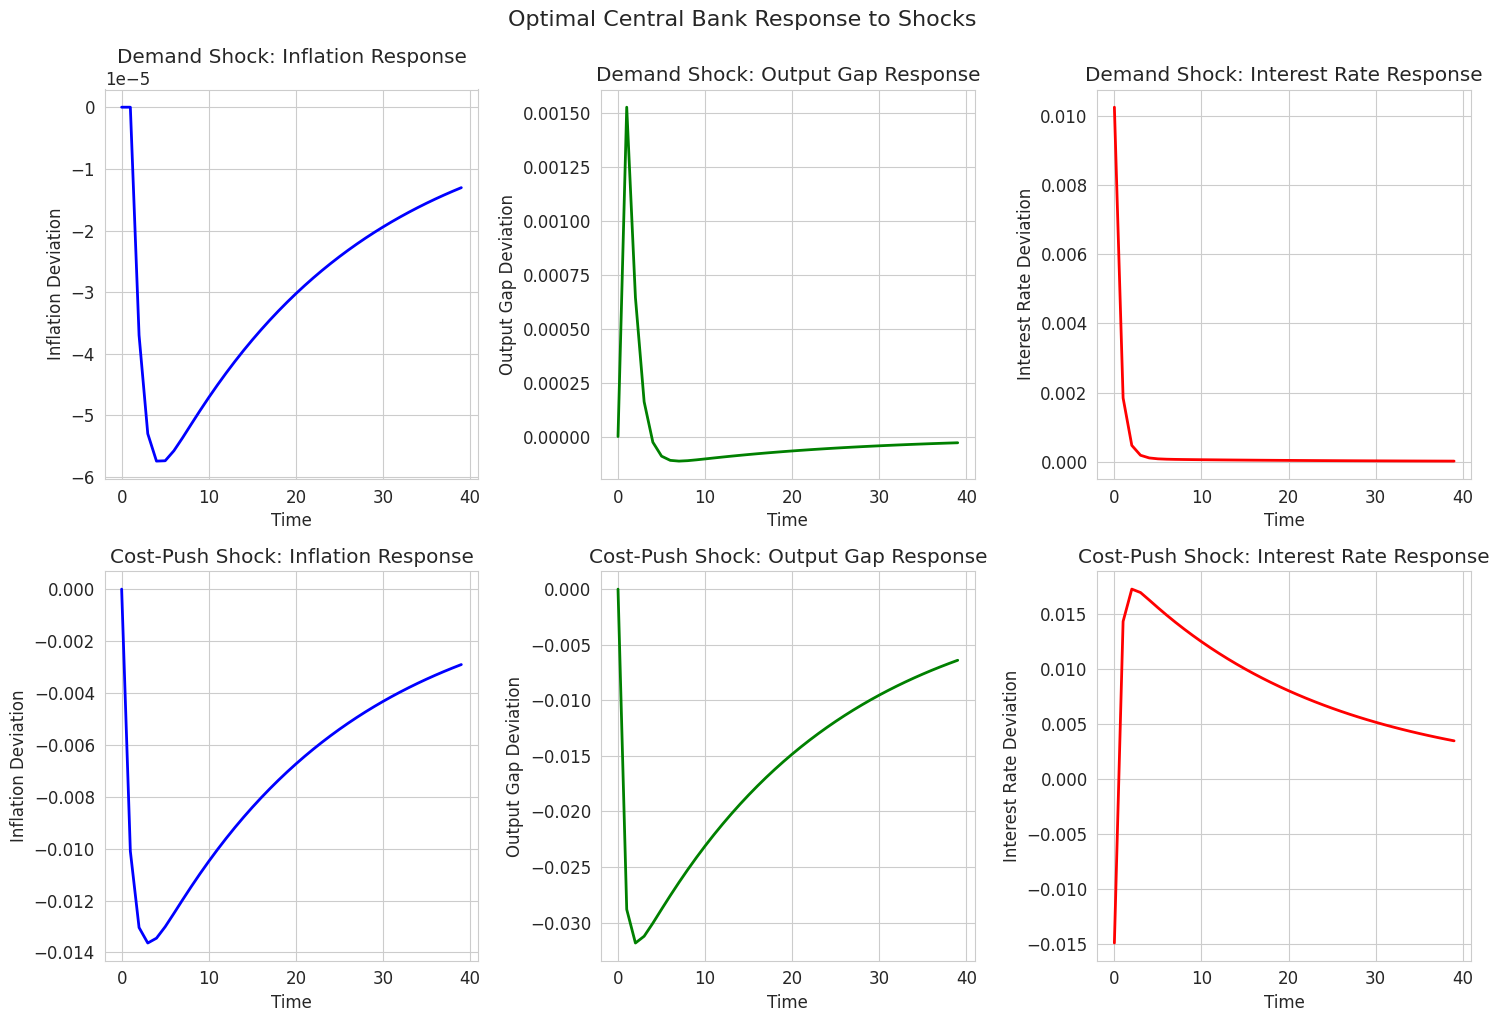

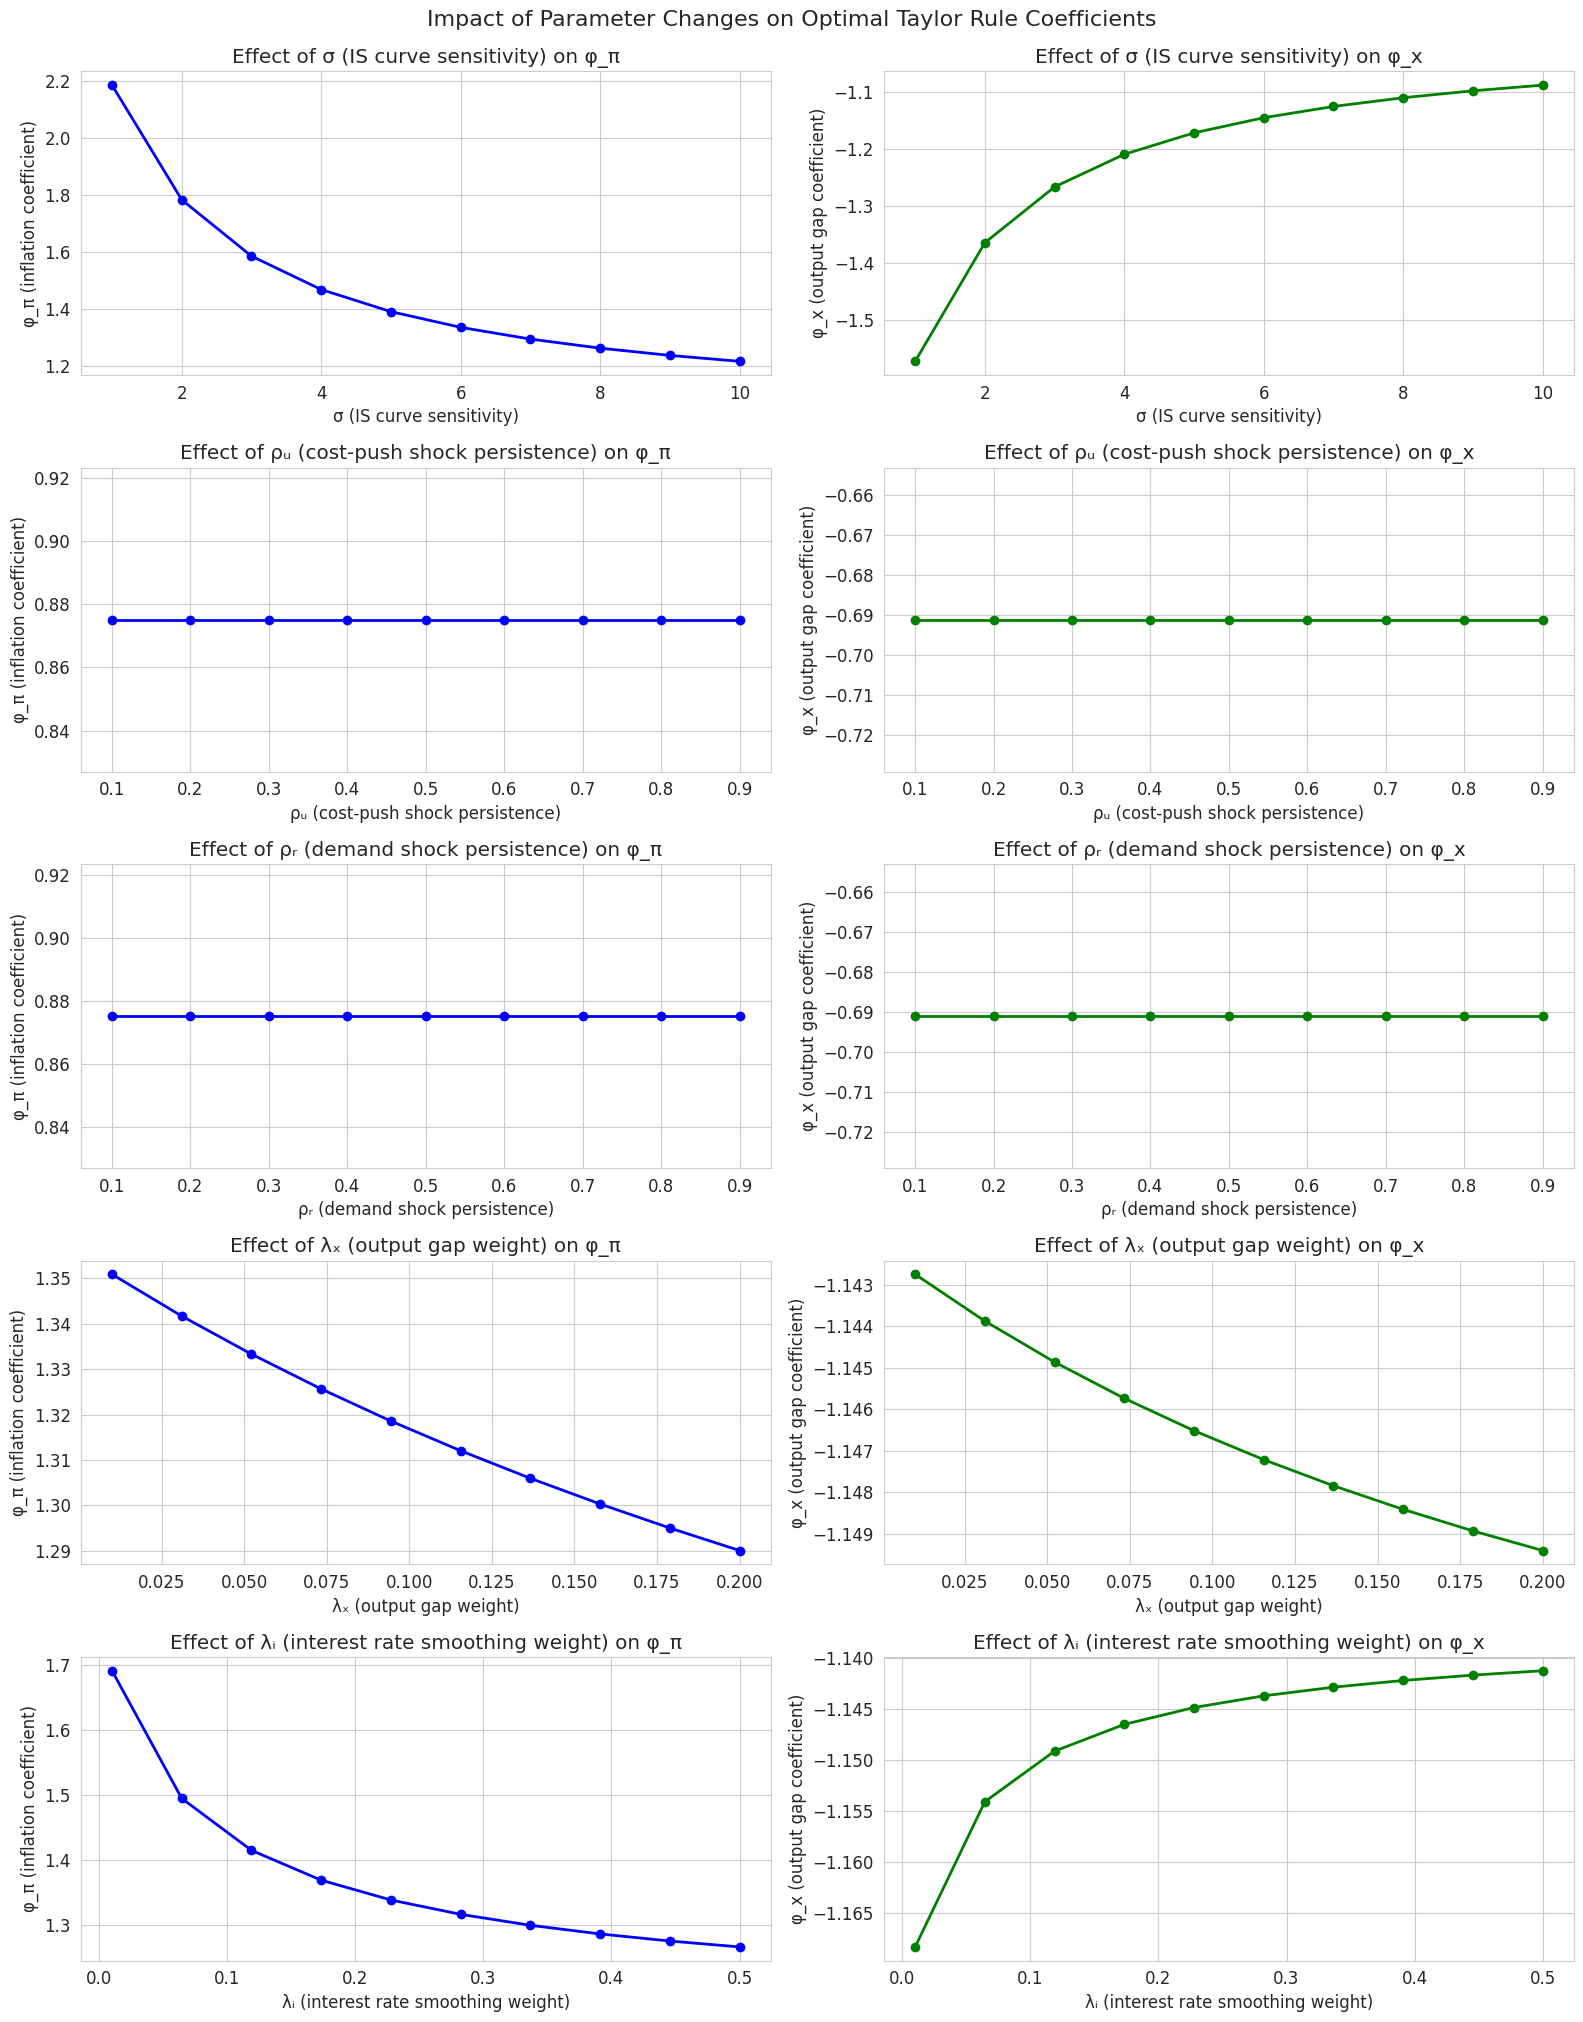

In [9]:
# 2. Simulate impulse response functions to shocks
demand_irf = simulate_irf(A, B, F, 'demand', shock_size=0.01)
cost_push_irf = simulate_irf(A, B, F, 'cost_push', shock_size=0.01)

# 3. Perform parameter sensitivity analysis
sensitivity_results = parameter_sensitivity_analysis()

# 4. Plot results
irf_fig = plot_irfs(demand_irf, cost_push_irf)
sensitivity_fig = plot_sensitivity_results(sensitivity_results)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 7.3 MB/s eta 0:00:00
